In [ ]:
!pip install shap

In [256]:
import numpy as np
import pandas as pd
from random import shuffle

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

import shap

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from itertools import product
from tqdm.notebook import tqdm

In [229]:
rcParams['figure.figsize'] = 10,10

In [ ]:
sns.set(rc={'figure.figsize':(20,20)})
rcParams['figure.figsize'] = 10,10

path_train = '/content/train_auto.csv'
path_test = '/content/test_auto.csv'

train_copy = pd.read_csv(path_train)
train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

# Utils

In [ ]:
def strdollars2int(inp):
  if inp != inp: # Deal with NaN
    return inp
  return int(inp.replace("$","").replace(",",""))

In [198]:
def find_Optimal_threshold(target, probs_predicted):
  threshs = np.arange(0,1,0.01)
  acc_p_threshs = np.array([accuracy_score(target, (probs_predicted > x) * 1) for x in threshs])
  return threshs[np.argmax(acc_p_threshs)]

In [200]:
class DUWGridSearchError(BaseException):
  pass

class DUWGridSearch:
  def __init__(self, grid, model_type='xgb'):
    self.param_names, self.param_values = zip(*list(grid.items()))
    self.model_type = model_type
    self.result_grid = list()

  def fit(self, train_set, eval_set, eval_metric='auc'):
    for value_combination in tqdm(product(*self.param_values)):
      param_grid = dict(tuple(zip(self.param_names, value_combination)))
      if self.model_type == 'xgb':
        model = xgb.XGBClassifier(objective='binary:logistic', **param_grid)
      self.report(model, train_set, eval_set, eval_metric, param_grid)


  def fit_and_evaluate(self, model, X_train, y_train, eval_set, eval_metric):
    model.fit(X_train, y_train, eval_set=[eval_set], early_stopping_rounds=50, eval_metric=eval_metric, verbose=False)
    probs_class_one = model.predict_proba(eval_set[0])[:,1]
    best_threshold = find_Optimal_threshold(y_dev, probs_class_one)
    predictions = (probs_class_one >= best_threshold) * 1
    return accuracy_score(y_dev, predictions), best_threshold
  
  def report(self, model, train_set, eval_set, eval_metric, param_grid):
    X_train, y_train = train_set
    rmse, bst_thresh = self.fit_and_evaluate(model, X_train, y_train, eval_set, eval_metric)
    self.result_grid.append((param_grid, rmse, bst_thresh))
  
  def return_best(self):
    if len(self.result_grid) < 1:
      raise DUWGridSearchError('You should fit your model.')
    return sorted(self.result_grid, key= lambda x: x[1])[-1]

In [282]:
def preprocess(df):
  ### 1 ###
  for false_cat in false_cat_columns:
    df[false_cat] = df[false_cat].apply(lambda x: strdollars2int(x))

  ### 2 ###
  for x in binary_cat:
    df[x] = bincol2enc[x].transform(df[x])
  
  ### 3 ###
  df['EDUCATION'] = df.EDUCATION.map(lbl2enc)

  ### 4 ###
  df = pd.get_dummies(df, prefix=['JOB', 'CAR_TYPE'], columns=['JOB', 'CAR_TYPE'])

  return df


# Global Analysis

In [ ]:
train_df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [ ]:
test_df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,3,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
1,9,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,z_No,M,z_High School,Manager,21,Private,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
2,10,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,z_No,z_F,z_High School,z_Blue Collar,30,Commercial,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
3,18,NaN,NaN,0,35.0,2,NaN,"$21,204",Yes,$0,z_No,M,z_High School,Clerical,74,Private,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
4,21,NaN,NaN,0,59.0,0,12.0,"$87,460",No,$0,z_No,M,z_High School,Manager,45,Private,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban


Well I suppose that TARGET_AMT is also a variable to predict, but since we are only asked to make a prediction on TARGET_FLAG, we will drop this column.

In [ ]:
train_df = train_df.drop(['INDEX', 'TARGET_AMT'], axis=1)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   object 
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   object 
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non-null   object 
 19  CLM_FR

Five variables have missing values (I didn't take into account the Age, only 6 values are missing). The ratio of missing values for each variable is insignificant (less than 5% is missing), I will let Xgboost deal with that (since it can handle missing values).

In [ ]:
train_df.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,0.171057,44.790313,0.721235,10.499286,33.485725,5.351305,0.798554,1.695503,8.328323
std,0.440728,0.511534,8.627589,1.116323,4.092474,15.908333,4.146635,1.158453,2.147112,5.700742
min,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000


In [ ]:
false_cat_columns = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']  # False Cat Variable (False because it's supposed to be a figure)
cat_columns = ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY'] # Cat Variable
num_columns = [x for x in train_df.drop(labels='TARGET_FLAG', axis=1).columns if x not in cat_columns]

# Data Analysis

## Categorical Variable
I will first convert the false categorical variable to continuous varibale.

In [ ]:
for false_cat in false_cat_columns:
  train_df[false_cat] = train_df[false_cat].apply(lambda x: strdollars2int(x))

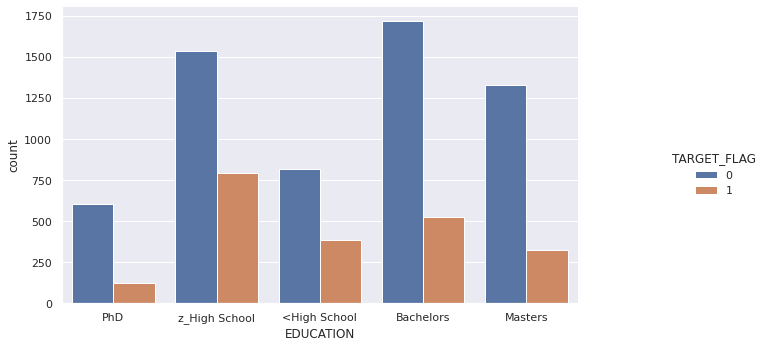

In [ ]:
plot = sns.catplot(x='EDUCATION', hue='TARGET_FLAG', data=train_df, kind='count')
plot.fig.set_figwidth(12)

As we can see, having a PhD or Master will decrease the probability of having a Flag equal to 1 while being in High School will do the opposite.

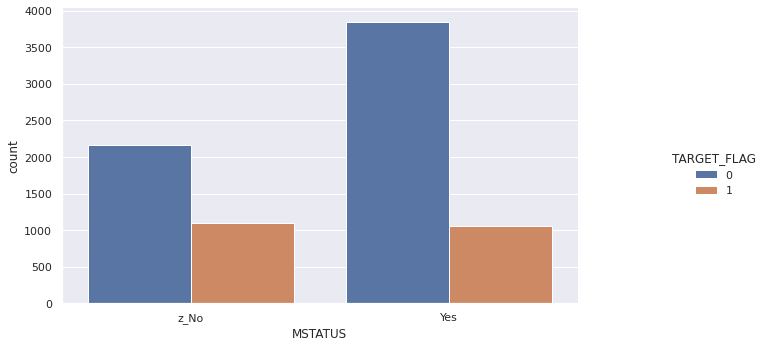

In [ ]:
plot = sns.catplot(x='MSTATUS', hue='TARGET_FLAG', data=train_df, kind='count')
plot.fig.set_figwidth(12)

Same thing here with having a MSTATUS==YES.

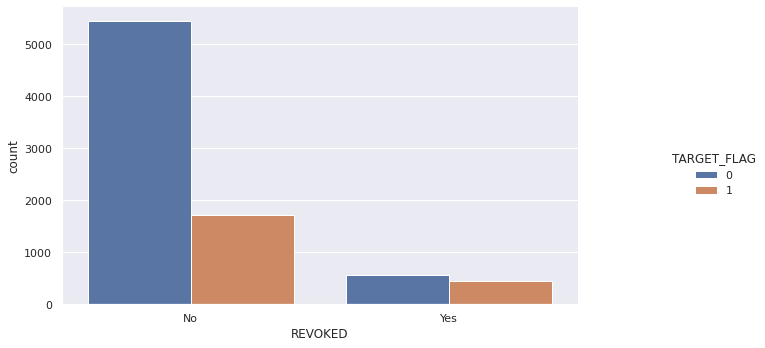

In [ ]:
plot = sns.catplot(x='REVOKED', hue='TARGET_FLAG', data=train_df, kind='count')
plot.fig.set_figwidth(12)

If you have revoked==yes, you probably have more chance to be in class 1. I think this problem deals with car accident and revoked means that we revoked the license driver.

## Numerical Variable

Instead of a data visualisation, I will compute the correlation features vs target.

In [ ]:
features = train_df[num_columns]
target = train_df['TARGET_FLAG']
correlation = features.corrwith(target)
sorted_correlation = abs(correlation).sort_values(ascending=False)

In [ ]:
sorted_correlation

MVR_PTS     0.219197
CLM_FREQ    0.216196
HOME_VAL    0.183737
INCOME      0.142008
OLDCLAIM    0.138084
HOMEKIDS    0.115621
KIDSDRIV    0.103668
BLUEBOOK    0.103383
AGE         0.103217
CAR_AGE     0.100651
TIF         0.082370
YOJ         0.070512
TRAVTIME    0.048368
dtype: float64

Well it looks like any of the numerical variable is correlated with the target. Let's do some visualisation.

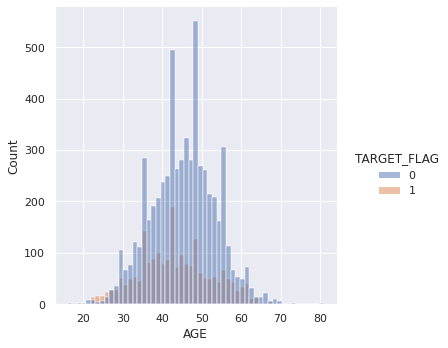

In [ ]:
sns.displot(x='AGE', hue='TARGET_FLAG', data=train_df)

The only difference concerns age between 20 and 25.

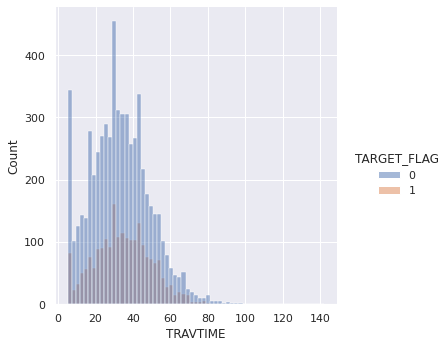

In [ ]:
sns.displot(x='TRAVTIME', hue='TARGET_FLAG', data=train_df)

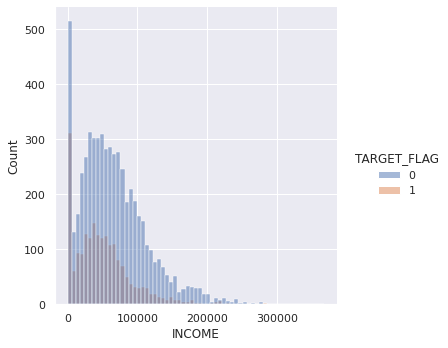

In [ ]:
sns.displot(x='INCOME', hue='TARGET_FLAG', data=train_df)

We get the same distribution, these features don't seem correlated to the target.

## Target Analysis

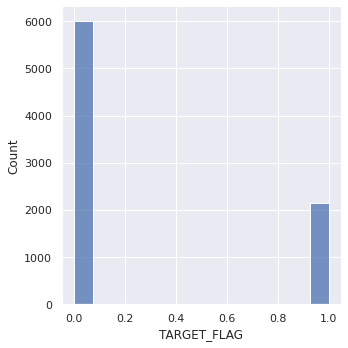

In [ ]:
sns.displot(data=train_df, x='TARGET_FLAG', kind='hist')

The dataset is unbalanced, we will probably focus on computing the AUC and plotting the ROC curve.

# Data preprocessing

In [ ]:
binary_cat = [x for x in cat_columns if len(train_df[x].unique()) <=2]
multi_cat = [x for x in cat_columns if x not in binary_cat]

## Binary

Since there are no missing values, I will only use simple LabelEncoder from sklearn

In [ ]:
binary_cat

['PARENT1', 'MSTATUS', 'SEX', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY']

In [ ]:
bincol2enc = dict()
for x in binary_cat:
  le = LabelEncoder()
  train_df[x] = le.fit_transform(train_df[x])
  bincol2enc[x] = le

## Multi

In [ ]:
multi_cat

['EDUCATION', 'JOB', 'CAR_TYPE']

### Education
For education I will choose a specific encoding since it's a grade


In [ ]:
train_df.EDUCATION.unique()

array(['PhD', 'z_High School', '<High School', 'Bachelors', 'Masters'],
      dtype=object)

In [ ]:
lbl2enc = {'<High School': 0, 'z_High School': 1, 'Bachelors': 2, 'Masters': 3, 'PhD': 4}
train_df['EDUCATION'] = train_df.EDUCATION.map(lbl2enc)

### Job & CarType

In [ ]:
train_df.JOB.unique()

array(['Professional', 'z_Blue Collar', 'Clerical', 'Doctor', 'Lawyer',
       'Manager', nan, 'Home Maker', 'Student'], dtype=object)

In [ ]:
train_df.CAR_TYPE.unique()

array(['Minivan', 'z_SUV', 'Sports Car', 'Van', 'Panel Truck', 'Pickup'],
      dtype=object)

In [ ]:
train_df = pd.get_dummies(train_df, prefix=['JOB', 'CAR_TYPE'], columns=['JOB', 'CAR_TYPE'])

# Modelisation

In [119]:
X, y = train_df.drop(labels='TARGET_FLAG', axis=1), train_df['TARGET_FLAG']
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.15, random_state=42)

## Naive Baseline

Naive baseline consist of predicting always the majority class

In [122]:
print(f"The accuracy of naive baseline is {accuracy_score(y_dev, np.array([0]*len(y_dev)))}")

The accuracy of naive baseline is 0.7363265306122448


## ML Baseline

In [188]:
clf_baseline = xgb.XGBClassifier(objective='binary:logistic')
clf_baseline.fit(X_train, y_train, eval_set=[(X_dev, y_dev)], early_stopping_rounds=50, eval_metric='auc', verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [199]:
probs_class_one = clf_baseline.predict_proba(X_dev)[:,1]
best_threshold = find_Optimal_threshold(y_dev, probs_class_one)
predictions = (probs_class_one >= best_threshold) * 1
print(f"The accuracy of xgb basline is {accuracy_score(y_dev, predictions)}")

The accuracy of xgb basline is 0.806530612244898


We had an improvement (compared to the naive baseline), it suggests that we can exploit the features to improve the result. <br>
Let's do some hyperparameter tuning.

## Hyperparameter tuning

In [201]:
param_grid = {"learning_rate"    : [0.05, 0.15, 0.30] ,
 "max_depth"        : [3, 5, 7, 9],
 "min_child_weight" : [3, 5, 7 ],
 "n_estimators"     : [100, 300, 500],
 "colsample_bytree" : [0.4, 0.6 ,0.8]}

In [202]:
grids = DUWGridSearch(param_grid)

In [203]:
grids.fit((X_train, y_train), (X_dev, y_dev))

0it [00:00, ?it/s]

In [207]:
grids.return_best()

({'colsample_bytree': 0.8,
  'learning_rate': 0.3,
  'max_depth': 3,
  'min_child_weight': 5,
  'n_estimators': 500},
 0.8179591836734694,
 0.51)

Small improvement ... <br>
However, the best threshold is between 0.48 and 0.52, so I think there is no need to compute the AUC score.

## Model Analysis

In [212]:
model = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=0.3, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=500)
model.fit(X_train, y_train, eval_set=[(X_dev, y_dev)], early_stopping_rounds=50, eval_metric='auc', verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [213]:
shap_values = shap.TreeExplainer(model).shap_values(X_dev)

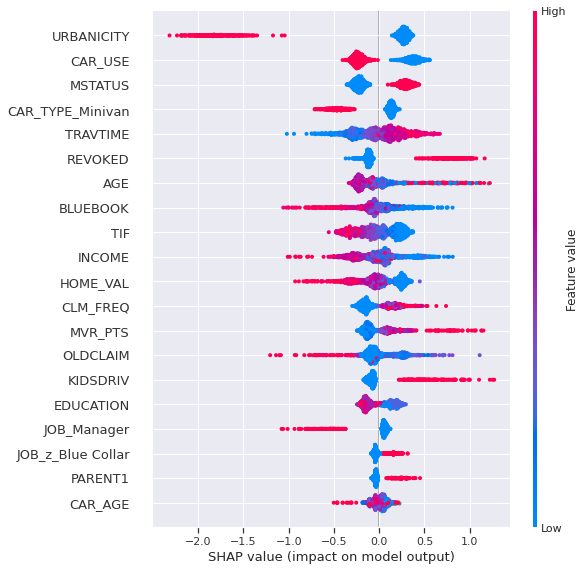

In [215]:
shap.summary_plot(shap_values, X_dev)

The primary relevant feature for accident crash is the type of city where we leave (Rural or Urban). The next most important indicator is which CAR we are using (Private or Commercial). Let's dive a little deeper.

### URBANICITY

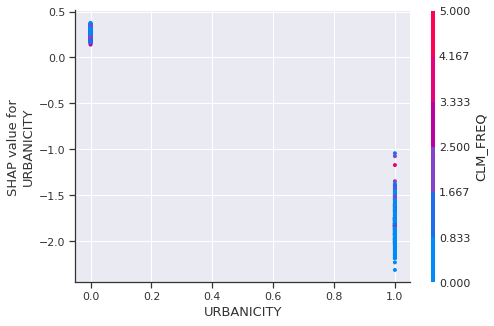

In [222]:
shap.dependence_plot("URBANICITY", shap_values, X_dev)

Here, every dot is a person and the vertical dispersion results from interaction effects in the model. CLM_FREQ was automatically chosen for coloring. Unfortunately It didn't give us much information.

### CAR USE

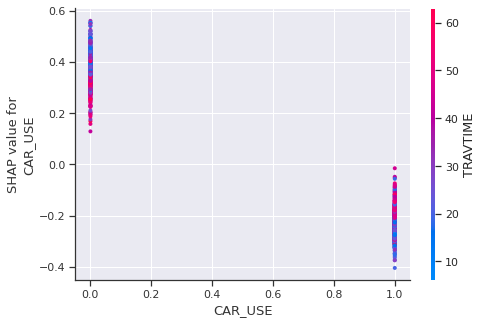

In [221]:
shap.dependence_plot("CAR_USE", shap_values, X_dev)

Here we can see the effect of having a certain kind of CAR and increasing the Travtime. I assume that Travtime refers to the time spend on the road. 

### CAR_TYPE_Minivan

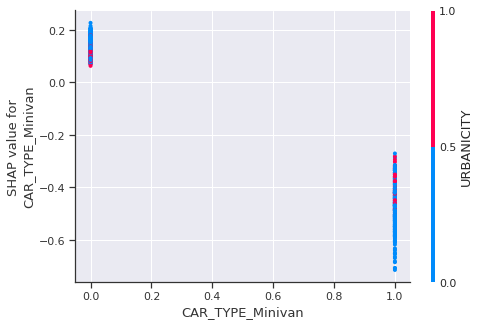

In [226]:
shap.dependence_plot("CAR_TYPE_Minivan", shap_values, X_dev)

Here we can see that having a Minivan and living in a certain city (that correspond to the label 0) decrease the probability of having a crash accident.

### TARGET_FLAG

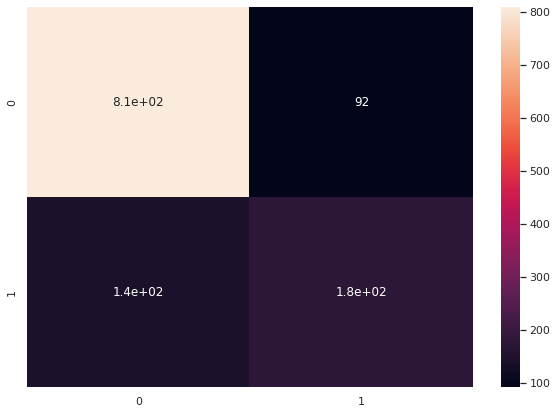

In [236]:
probs_class_one = model.predict_proba(X_dev)[:,1]
best_threshold = find_Optimal_threshold(y_dev, probs_class_one)
predictions = (probs_class_one >= best_threshold) * 1
mc = confusion_matrix(y_dev, predictions)
df_mc = pd.DataFrame(mc, index = [0,1],
                  columns = [0,1])
plt.figure(figsize = (10,7))
sns.heatmap(df_mc, annot=True)

The model is clearly failing to predict the target 1.

# Experiment
Let's do a fake ensemble oversampling. We will create 3 splits. We will have the same samples that correspond to the label 1 in all of them, but in each split we will have different samples that correspond to the label 0. The trick here is to have a balanced dataset and to train a xgboost model on each split and average the probability given by each model.

In [246]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [253]:
idx_class_one = np.where(y_train > 0)
train_one = X_train.loc[idx_class_one[0], :] # Keep training data that match the label 1
train_zero = X_train.drop(idx_class_one[0]) # Keep training data that match label 0

In [261]:
train_zero_idx = train_zero.index.tolist()
shuffle(train_zero_idx)

splits = [train_zero_idx[:1830], train_zero_idx[1830:3660], train_zero_idx[3660:]]
training_splits = [train_zero.loc[x, :] for x in splits]
y_splits = [np.array([0]*len(x) + [1]*len(train_one)) for x in splits]

In [272]:
sets = [(pd.concat([x, train_one]), y) for x, y in zip(training_splits, y_splits)]

In [274]:
models = list()
for x_tr, y_tr in sets:
  clf = xgb.XGBClassifier(objective='binary:logistic')
  clf.fit(x_tr, y_tr, eval_set=[(X_dev, y_dev)], early_stopping_rounds=50, eval_metric='auc', verbose=False)
  models.append(clf)

In [281]:
probs_class_one = (models[0].predict_proba(X_dev)[:,1] + models[1].predict_proba(X_dev)[:,1] + models[2].predict_proba(X_dev)[:,1])/3
best_threshold = find_Optimal_threshold(y_dev, probs_class_one)
predictions = (probs_class_one >= best_threshold) * 1
print(f"The accuracy of xgb basline is {accuracy_score(y_dev, predictions)}")

The accuracy of xgb basline is 0.8081632653061225


Well unfortunately it didn't improve the result so we will stick with the model we finetuned.

# Predictions

In [284]:
test_df = preprocess(test_df)

In [287]:
input_model = test_df.drop(['INDEX', 'TARGET_FLAG', 'TARGET_AMT'], axis=1)
probs_class_one = model.predict_proba(input_model)[:,1]
best_threshold = 0.51
predictions = (probs_class_one >= best_threshold) * 1

In [288]:
test_df['TARGET_FLAG'] = predictions

In [289]:
test_df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,JOB_Clerical,JOB_Doctor,JOB_Home Maker,JOB_Lawyer,JOB_Manager,JOB_Professional,JOB_Student,JOB_z_Blue Collar,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV
0,3,0,NaN,0,48.0,0,11.0,52881.0,0,0.0,1,0,2,26,1,21970,1,1,0,0,0,2,10.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,9,0,NaN,1,40.0,1,11.0,50815.0,1,0.0,1,0,1,21,1,18930,6,0,3295,1,0,2,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,10,0,NaN,0,44.0,2,12.0,43486.0,1,0.0,1,1,1,30,0,5900,10,0,0,0,0,0,10.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,18,0,NaN,0,35.0,2,NaN,21204.0,1,0.0,1,0,1,74,1,9230,6,0,0,0,1,0,4.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,21,0,NaN,0,59.0,0,12.0,87460.0,0,0.0,1,0,1,45,1,15420,1,1,44857,2,0,4,1.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [292]:
test_df.to_csv('/content/predictions.csv', index=False)